In [9]:
import numpy as np
from sklearn import metrics
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
plt.style.use("ggplot")

In [10]:
# run prediction forward
!python3 predictor.py  --outfile scratch/predictions_dsmall.csv --model ~/SIN/models/20200113T15:44/dsmall_100.pth

2020-01-13 20:59:34,911:prediction:INFO - predictor:main:41 - Reading params of /home/varun/SIN/models/20200113T15:44/dsmall_100.pth into the network defined in wbmv1.py
2020-01-13 20:59:34,918:lib.data:INFO - data:__init__:180 - Looking in /home/varun/SIN/data/pl_wbm/test for images
2020-01-13 20:59:34,918:lib.data:INFO - data:__init__:191 - Found 0 files in /home/varun/SIN/data/pl_wbm/test
2020-01-13 20:59:34,919:lib.data:INFO - data:__init__:191 - Found 448 files in /home/varun/SIN/data/pl_wbm/test/2
2020-01-13 20:59:34,925:lib.data:INFO - data:__init__:191 - Found 3006 files in /home/varun/SIN/data/pl_wbm/test/8
2020-01-13 20:59:34,926:lib.data:INFO - data:__init__:191 - Found 561 files in /home/varun/SIN/data/pl_wbm/test/1
2020-01-13 20:59:34,927:lib.data:INFO - data:__init__:191 - Found 753 files in /home/varun/SIN/data/pl_wbm/test/4
2020-01-13 20:59:34,928:lib.data:INFO - data:__init__:191 - Found 771 files in /home/varun/SIN/data/pl_wbm/test/3
2020-01-13 20:59:34,929:lib.data:I

In [11]:
df = pd.read_csv("scratch/predictions_dsmall.csv")


In [20]:

yhat = df.prediction
labs = df.label

# courtesy of sklearn
fpr, tpr, thresholds = metrics.roc_curve(labs, yhat)
roc_auc = metrics.auc(fpr, tpr)

rocdf = pd.DataFrame({"fpr":fpr, "tpr":tpr, "thresh": map(lambda x: round(x, 4), thresholds)})

# https://github.com/scikit-learn/scikit-learn/pull/10591/files

prc = metrics.precision_recall_curve(labs, yhat)
prcdf = pd.DataFrame({"precision": prc[0][:-1], "recall": prc[1][:-1], "thresholds": prc[2]})


/home/varun/.local/lib/python3.6/site-packages/sklearn/metrics/ranking.py:651: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


In [25]:
np.isnan(roc_auc)

True

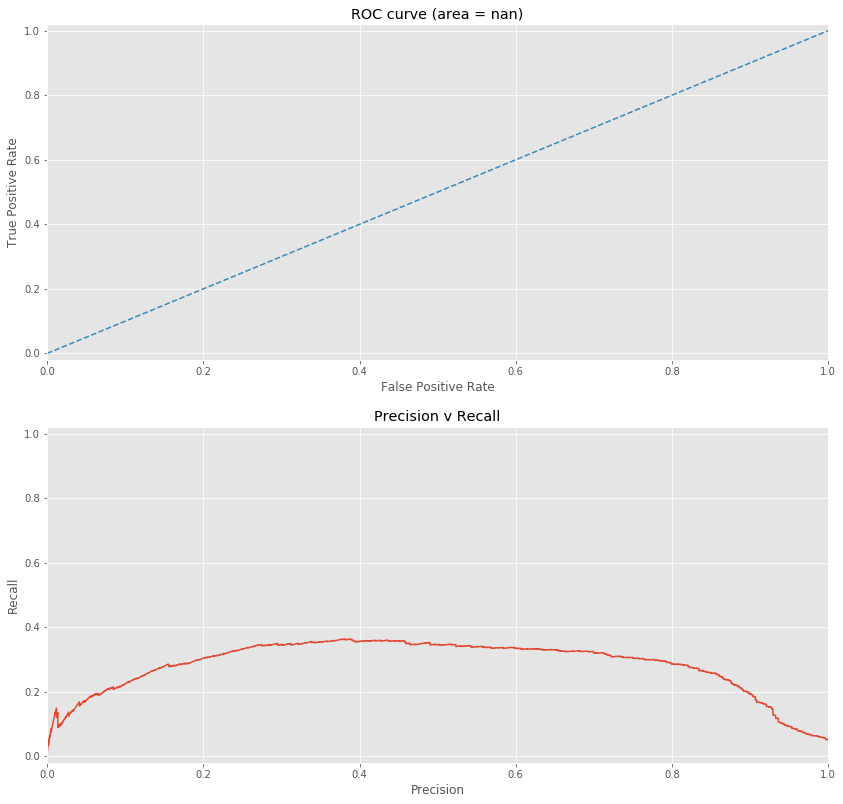

In [23]:
plt.figure(figsize=(14,21))
plt.subplot(311)

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([-0.02, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve (area = %0.2f)' % roc_auc);

# Precision Recall
plt.subplot(312)
plt.plot(prcdf.recall, prcdf.precision)
plt.xlim([0.0, 1.0])
plt.ylim([-0.02, 1.02])
plt.xlabel('Precision')
plt.ylabel("Recall")
plt.title("Precision v Recall");


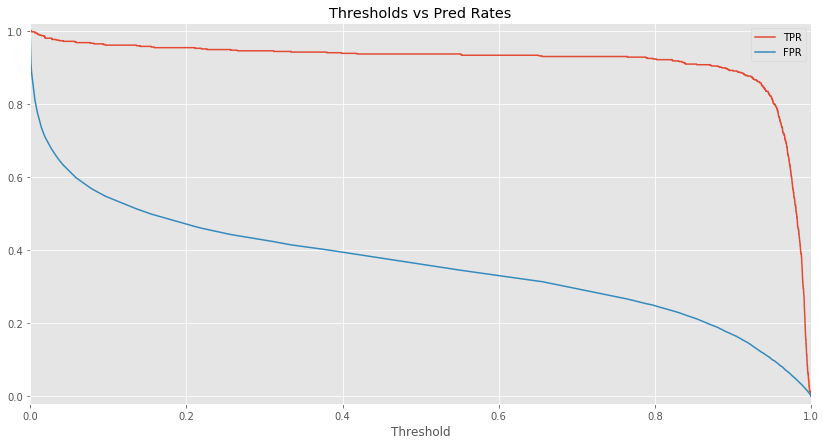

In [62]:
plt.figure(figsize=(14, 7))
plt.xlim([0.0, 1.0])
plt.ylim([-0.02, 1.02])
plt.plot(thresholds[1:], tpr[1:], label="TPR")
plt.plot(thresholds[1:], fpr[1:], label="FPR")
plt.xlabel("Threshold")
plt.legend()
plt.title("Thresholds vs Pred Rates");


In [296]:
rocdf[np.logical_and(rocdf.fpr < 0.2, rocdf.tpr > .8)]

fpr       tpr  thresh
634  0.098623  0.801382  0.9518
635  0.098878  0.801382  0.9515
636  0.098878  0.803109  0.9515
637  0.099218  0.803109  0.9512
638  0.099218  0.806563  0.9512
..        ...       ...     ...
748  0.188488  0.903282  0.8806
749  0.195545  0.903282  0.8723
750  0.195545  0.905009  0.8721
751  0.196905  0.905009  0.8706
752  0.196905  0.906736  0.8705

[119 rows x 3 columns]

FPR: 0.20, TPR: 0.91
F1: 0.31
Precision : 0.185, recall: 0.907


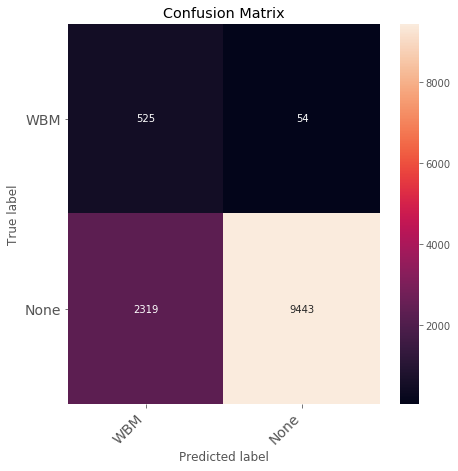

In [144]:
def thresh_metrics(thresh = 0.87):
    cm = metrics.confusion_matrix(1-labs, yhat <= thresh)
    df_cm = pd.DataFrame(
        cm, index=["WBM", "None"], columns=["WBM", "None"], 
    )
#     print(df_cm)
    fig = plt.figure(figsize=(7,7))
    plt.title("Confusion Matrix")
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=14)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    idx = len(rocdf) - np.searchsorted(rocdf.thresh[::-1], thresh, side="right") - 1
    stats = rocdf.iloc[idx]
#     print(stats)
    print(f"FPR: {stats.fpr:.2f}, TPR: {stats.tpr:.2f}")
    f1 = metrics.f1_score(labs, yhat > thresh)
    print(f"F1: {f1:.2f}")
    
    idx = np.searchsorted(prcdf.thresholds, thresh, side="left")
    
    stats = prcdf.iloc[idx]
#     print(idx, stats)
    print(f"Precision : {stats.precision:.3f}, recall: {stats.recall:.3f}")
    
    
thresh_metrics(.87)

In [220]:
# false negatives
false_negatives = df[np.logical_and(df.label==1, df.prediction < .87)].sort_values("prediction")
false_negatives.head()

file  label  prediction
5182   /home/varun/SIN/data/pl_wbm/test/6/2611.jpg      1    0.001153
9446   /home/varun/SIN/data/pl_wbm/test/8/0117.jpg      1    0.002012
9444   /home/varun/SIN/data/pl_wbm/test/8/0115.jpg      1    0.006123
11459  /home/varun/SIN/data/pl_wbm/test/8/2219.jpg      1    0.006711
11458  /home/varun/SIN/data/pl_wbm/test/8/2218.jpg      1    0.009202

In [210]:
# false pos
false_positives = df[np.logical_and(df.label==0, df.prediction > .87)].sort_values("prediction", ascending=False)
false_positives

file  label  prediction
847    /home/varun/SIN/data/pl_wbm/test/2/418.04.jpg      0    0.999999
4968     /home/varun/SIN/data/pl_wbm/test/6/2387.jpg      0    0.999998
710   /home/varun/SIN/data/pl_wbm/test/2/1538.04.jpg      0    0.999953
3879     /home/varun/SIN/data/pl_wbm/test/6/1251.jpg      0    0.999943
4963     /home/varun/SIN/data/pl_wbm/test/6/2382.jpg      0    0.999932
...                                              ...    ...         ...
4151     /home/varun/SIN/data/pl_wbm/test/6/1534.jpg      0    0.870669
5649     /home/varun/SIN/data/pl_wbm/test/6/3099.jpg      0    0.870576
8098     /home/varun/SIN/data/pl_wbm/test/7/1924.jpg      0    0.870341
7745     /home/varun/SIN/data/pl_wbm/test/7/1557.jpg      0    0.870125
5693     /home/varun/SIN/data/pl_wbm/test/6/3145.jpg      0    0.870097

[2319 rows x 3 columns]

In [280]:
from PIL import Image, ImageDraw

def collage_image(df, collage=3, shrinkfac=2, random=True):
    shrink = collage * shrinkfac

    sel = df
    if random:
        sel = df.sample(collage ** 2)
        
    sel = (row for _, row in sel.iterrows())

    w, h = (1920// shrink, 1080//shrink)

    newim = Image.new("RGB", (w*collage, h*collage))
    img_draw = ImageDraw.Draw(newim)
    import itertools
    for im, st in zip(sel, itertools.product(range(collage), range(collage))):
        p = PIL.Image.open(im.file).resize((w, h))
        sf = "/".join(im.file.rsplit("/", 2)[-2:])[:-4]

        newim.paste(p, (w*st[1], h * st[0]))
        img_draw.text((w * (st[1] +.2) ,h * (st[0]+.8)), 
                      f"{sf}:  {round(im.prediction, 4)}")
        
    return newim.resize((1920, 1080))

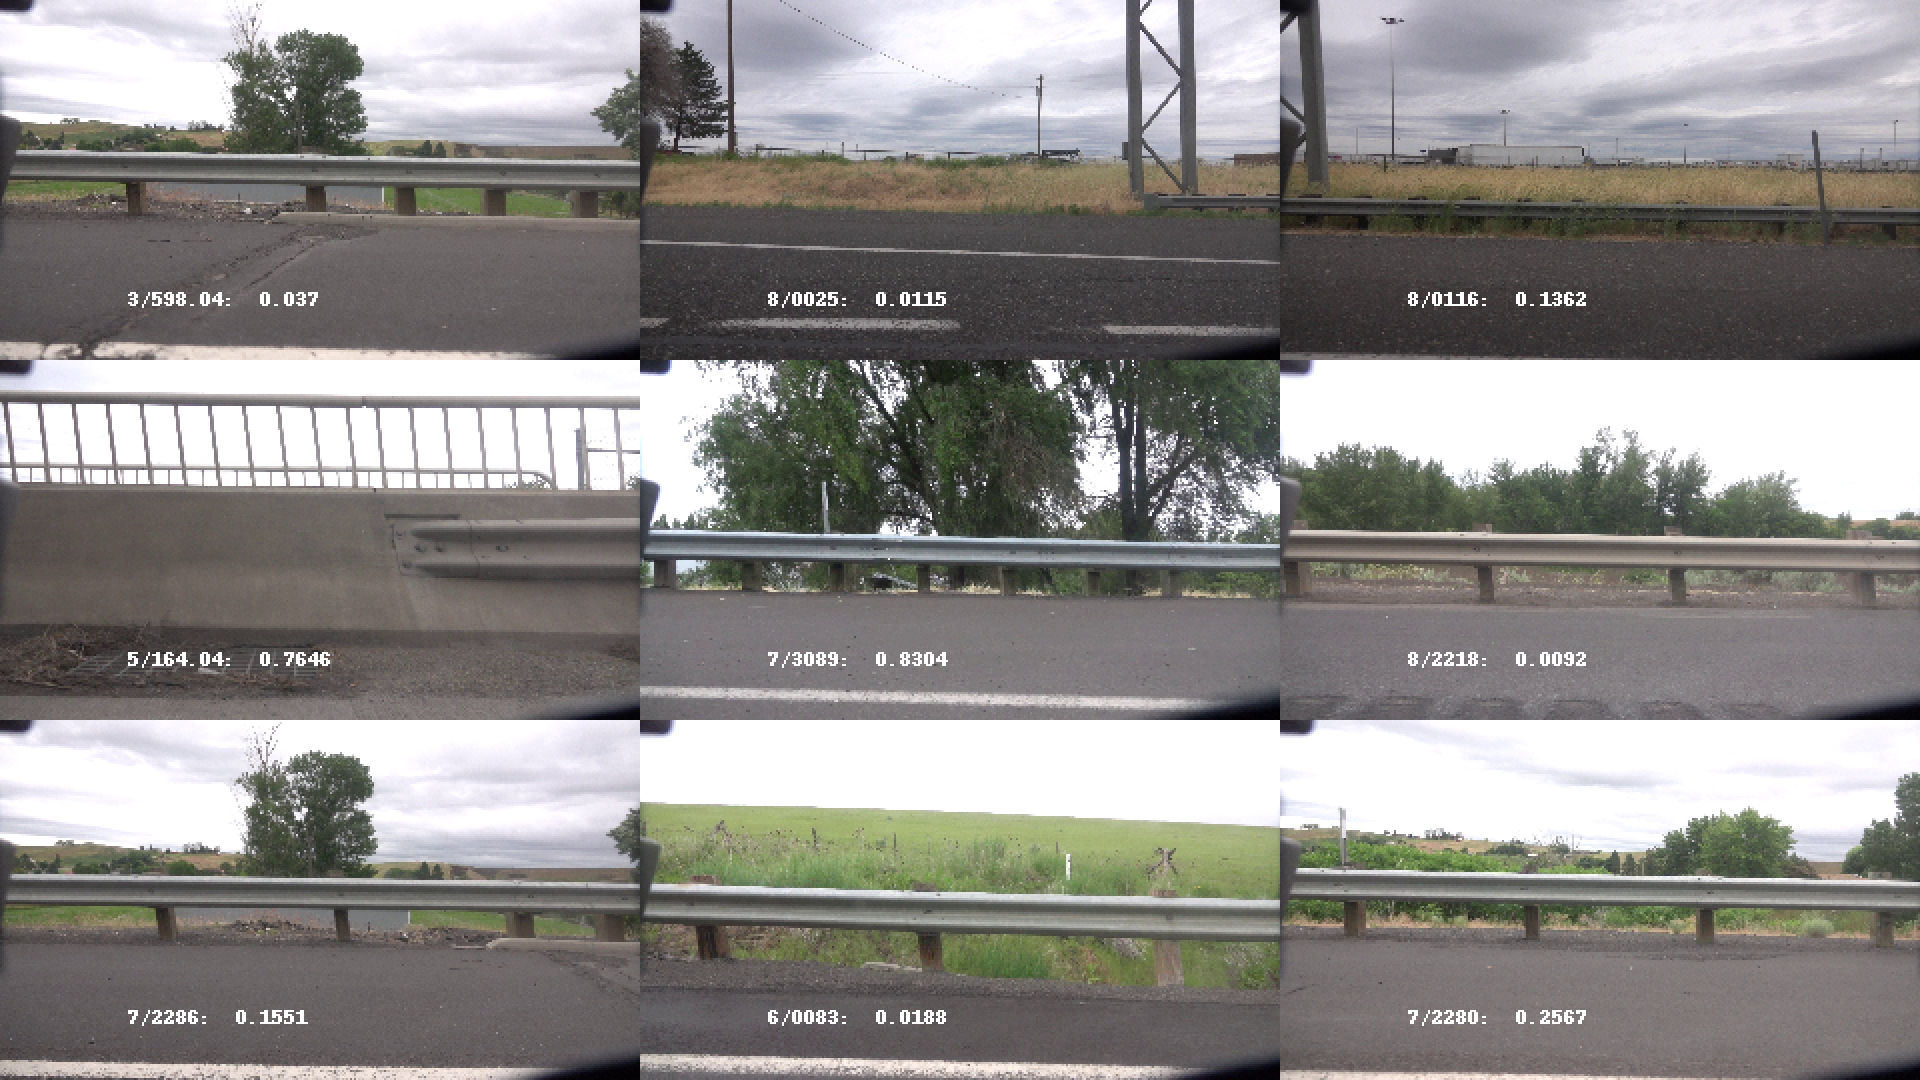

In [282]:
collage_image(false_negatives)

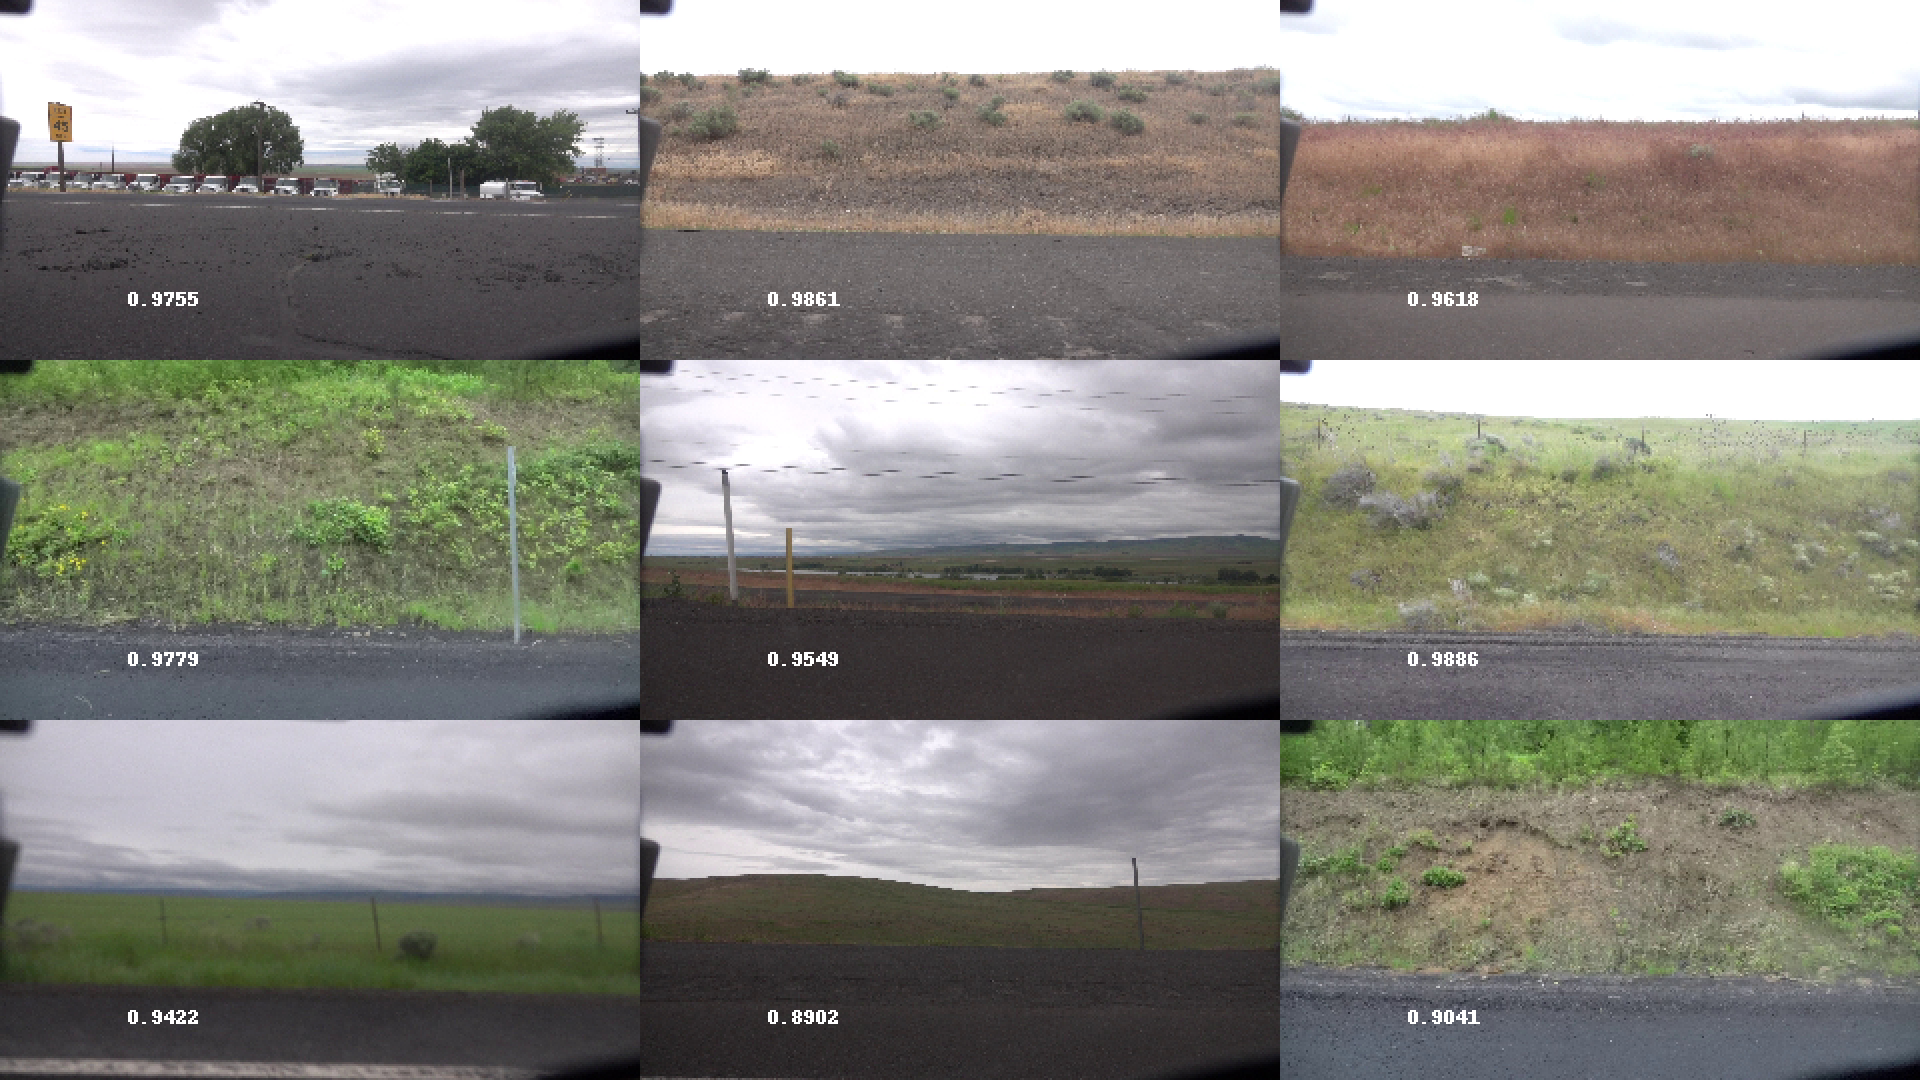

In [255]:
collage_image(false_positives, random=True)

In [4]:
from lib.data import WBMTest

In [5]:
from torch.utils.data import DataLoader
d = DataLoader(WBMTest())

In [7]:
len(d)

12341